<a href="https://colab.research.google.com/github/glarmour/Congressional-Analytics/blob/main/SnapChat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Group Members
## Ehab Abdo
eabdo@calpoly.edu
## Greg Larmour
glarmour@calpoly.edu
## Harrison Pearce
hlpearce@calpoly.edu
 
GSB 521 - Pierce
 
16 March 2023

# Introduction

# Data Importation

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 44.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp39-cp39-linux_x86_64.whl size=61826410 sha256=de2762d6c91f3e2e77a32c3470c0a948c5fdd532a4546f3072e39fbdc39464d9
  Stored in directory: /root/.cache/pip/wheels/b8/36/bf/7ec7e363f796373cea3eb9ea94e83f5bbbb586d2edbf7e3417
Successfully built pystan
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 803.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9436124 sha256=1099618ee68d780ba89ab2befe156e9e5a3874e09f8a6a0e39677a2fc1e30f2a
  Stored in directory: /root/.cache/pip/wheels/da/a4/bb/dbed5db92b2183a753dd96cc8a56706a61484ff395998

In [ ]:
#import needed packages
# !pip install pyjanitor==0.23.1
import pandas as pd
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
import json
import numpy as np
import seaborn as sns
# import janitor
import datetime
import statsmodels.api as sm
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, LabelSet
import plotly.graph_objects as go
from bokeh.models import LinearColorMapper, ColorBar
from bokeh.transform import transform
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go
# from fbprophet import Prophet

pd.options.display.max_columns = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/AWS_Final_Project/usage_pre_covid_nordic.csv'
snap = pd.read_csv(path)

#snapA = snap.groupby('event_date')['APP_APPLICATION_OPEN_UU'].sum().reset_index()

FileNotFoundError: ignored

# Question1 : What will the average Q1'2020 DAU be?


The SnapChat daily active user (DAU) data provided for Nordic countries covers approximately 9 days after the lockdowns in Norway and Denmark, which were implemented on March 12th and 13th, 2020, respectively. By analyzing this 9-day period, which was significantly affected by the COVID-19 pandemic, we can have a high degree of confidence that the upward trend in DAU has continued to rise at a similar pace until the end of Q1. Accordingly, we adjusted our forecast model parameters to better reflect the lockdown period's profile while also accounting for the long-term trend.

In [ ]:
#####  prophet model1 preparation

# preparing training data
train_data = snap.groupby('event_date')['APP_APPLICATION_OPEN_UU'].sum().reset_index().rename(columns={'event_date': 'ds', 'APP_APPLICATION_OPEN_UU': 'y'})
train_data['ds'] = pd.to_datetime(train_data['ds'])

# pre and post covid seasonality
train_data = train_data.copy()
train_data['pre_covid'] = pd.to_datetime(train_data['ds']) < pd.to_datetime('2020-03-13')
train_data['post_covid'] = ~train_data['pre_covid']

# lockdown period to be treated as holidays
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-05-29'}])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

In [ ]:
##### Model1

# Select certain number of historical days to use for training
#train_data = train_data[train_data['ds'] > train_data['ds'].max() - pd.Timedelta(days=40)]

# design model
m1 = Prophet(
   changepoint_prior_scale=1,
   n_changepoints=10,
   seasonality_prior_scale = 5,
   holidays = lockdowns,
   yearly_seasonality= True,
   seasonality_mode = 'multiplicative',
#  changepoints=['2020-03-13'],
#  weekly_seasonality=False,
)
m1.add_seasonality(name='weekly_pre_covid', period=7, fourier_order=3, condition_name='pre_covid',)
m1.add_seasonality(name='weekly_post_covid',period=7,fourier_order=3,condition_name='post_covid',)

# fit model
m1 = m1.fit(train_data)
future1 = m1.make_future_dataframe(periods=10)
future1['pre_covid'] = pd.to_datetime(future1['ds']) < pd.to_datetime('2020-03-13')
future1['post_covid'] = ~future1['pre_covid']

# predict
forecast1 = m1.predict(future1)

# forecast plot
plot_plotly(m1, forecast1)

#plot_components_plotly(m1, forecast1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [ ]:
##### Q1 DAU Forecast

train_data.set_index('ds', inplace=True)
forecast1.set_index('ds', inplace=True)

# Q1 actual data
start_date = '2020-1-1'
end_date = '2020-3-21'
Q1_actual = train_data.loc[start_date:end_date, 'y'].sum()
Q1_actual
# Q1 forecasted 
start_date = '2020-3-22'
end_date = '2020-3-31'
Q1_forecasted = forecast1.loc[start_date:end_date, 'yhat'].sum()
Q1_forecasted

Q1_Total = Q1_actual + Q1_forecasted
Q1_Avg_DAU = Q1_Total/91
Q1_Avg_DAU

6941142.071420218

Q1-2020 forecasted DAU

In [ ]:
print("SnapChat forecasted Q1-2020 DAU is {}".format(round(Q1_Avg_DAU)))

SnapChat forecasted Q1-2020 DAU is 6941142


# Question 2: What range will you forecast for average Q2'2020 DAU?

## Approach and External Data

In order to calculate our Q2 forecast for Snapchat's DAU, we sought external data that could serve as a proxy for snapchat user behavior change after covid. Our aim was to use this data to design and validate our forecasting model. Specifically, we wanted to find relevant data that could help answer two key questions:

**First: What is the estimated month-over-month increase in DAU over Q2?**

Given that we only had 9 days of data from the provided dataset that were impacted by the COVID-19 lockdown, we looked for other proxy variables with daily, monthly, or quarterly data available for Nordic countries to help validate and tune our model results. After searching for relevant data, we found that Netflix's DAU data for Nordic countries (source: statista.com) might be a good proxy for Snapchat's DAU. Below figure illustrates that the Netflix DAU trend in Denmark showed a MoM increase of approximately 14% in April, followed by a recovery to normal trend in May, and a return to full normality in June. Norway showed a similar trend.







*Netflix Monthly DAU in Denmark*

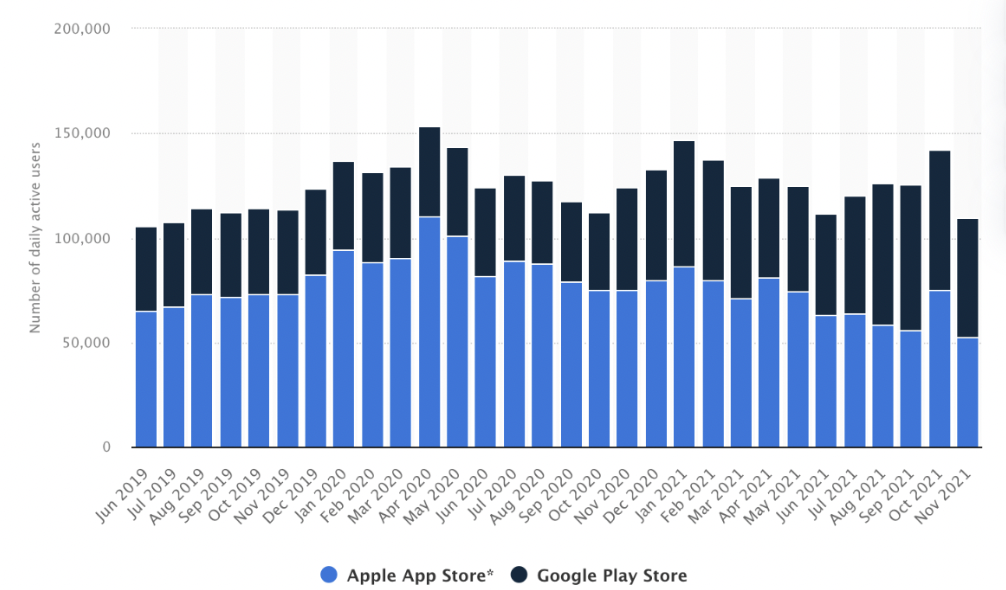

**Second: Peak, stabelize and Recovery Dates Estimates**

We were unable to find external data that would be a direct proxy for Snapchat's daily behavioral trend following the COVID-19 lockdown. However, we hypothesized that our trend might follow the trend profile of power usage data, which would reflect changes in the daily lifestyle routines. The power usage data for Nordic countries showed that the tear-over-year difference between 2019 and 2020, peaked around April 11th to 13th, stabilized for a couple of weeks, and reached full recovery to normal trend by the first week of June. Below figure illustrates a sample power usage trend in Norway, which we collected from a trusted governmental website report (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8647432/).

*Daily power consumpption in Norway (YoY)*
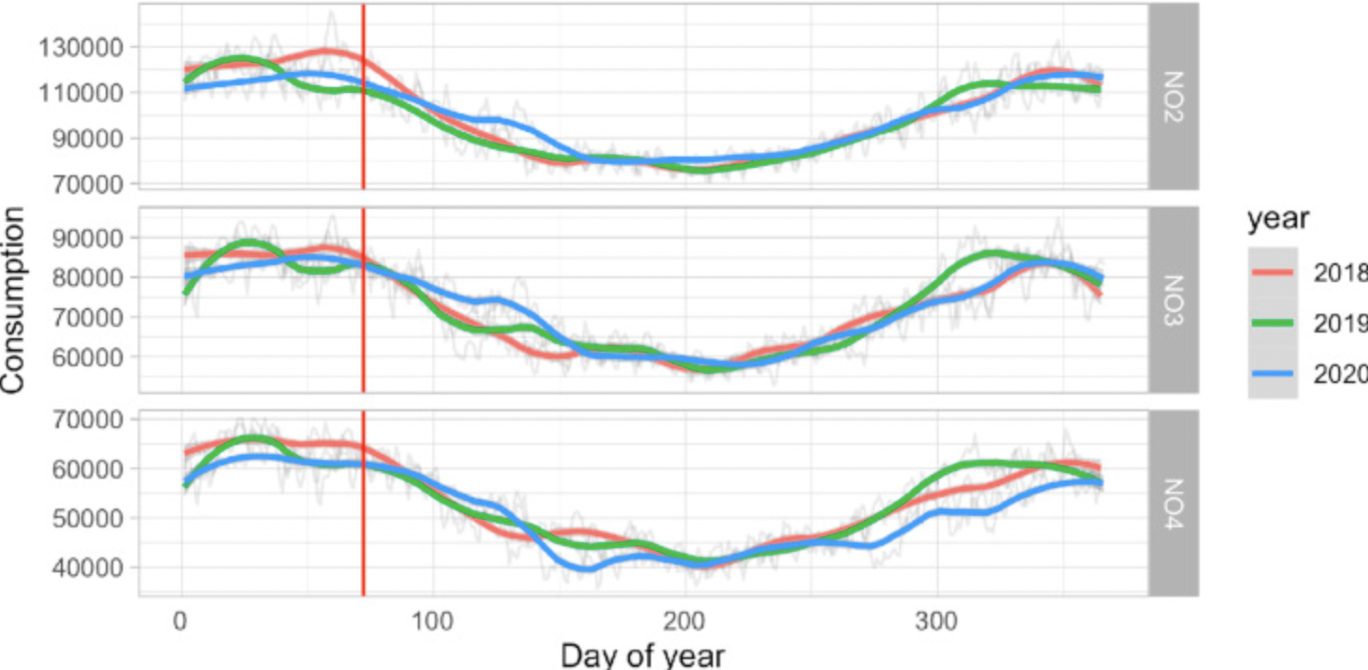

## Model Design and Results

We performed several parameter tunings for our forecasting model to control for the lockdown impact taking into consideration the guidelines developed from the Netflix DAU, the lifestyle changes represented by the daily power consumption trends, and the published Snapchat worldwide and regional DAU data for 2019/2020.
 After extensive modeling and analysis, we arrived at a model that we believed would be decent enough, given the available data. Our final Q2 forecast predicted an average of **7.29M DAU** with around  **5% increase over Q1-2020**. This increase is in line with the average Snapchat published quarterly DAU change worldwide and slightly higher than the more conservative figures of Europe and North America as per statista.com.

In [ ]:
#####  prophet model2 preparation

# preparing training data
train_data = snap.groupby('event_date')['APP_APPLICATION_OPEN_UU'].sum().reset_index().rename(columns={'event_date': 'ds', 'APP_APPLICATION_OPEN_UU': 'y'})
train_data['ds'] = pd.to_datetime(train_data['ds'])

# pre and post covid seasonality
train_data = train_data.copy()
train_data['pre_covid'] = (pd.to_datetime(train_data['ds']) >= pd.to_datetime('2020-03-13')) & (pd.to_datetime(train_data['ds']) <= pd.to_datetime('2020-04-10'))
train_data['post_covid'] = ~train_data['pre_covid']

# lockdown period to be treated as holidays
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-04-10'}])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

In [ ]:
##### Model2
# Select certain number of historical days to use for training
#train_data = train_data[train_data['ds'] > train_data['ds'].max() - pd.Timedelta(days=40)]

# design model
m2 = Prophet(
   changepoint_prior_scale=0.4,
   n_changepoints=12,
   seasonality_prior_scale = 1,
   holidays = lockdowns,
  yearly_seasonality= True,
 #  seasonality_mode = 'multiplicative',
#  changepoints=['2020-03-13'],
#  weekly_seasonality=False,
)
m2.add_seasonality(name='weekly_pre_covid', period=7, fourier_order=3, condition_name='pre_covid',)
m2.add_seasonality(name='weekly_post_covid',period=7,fourier_order=3,condition_name='post_covid',)

# fit model
m2 = m2.fit(train_data)
future2 = m2.make_future_dataframe(periods=101)
future2['pre_covid'] = (pd.to_datetime(future2['ds']) >= pd.to_datetime('2020-03-13')) & (pd.to_datetime(future2['ds']) <= pd.to_datetime('2020-04-10'))
future2['post_covid'] = ~future2['pre_covid']

# predict
forecast2 = m2.predict(future2)

# forecast plot
plot_plotly(m2, forecast2)

#plot_components_plotly(m2, forecast2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Q2-2020 SnapChat forecasted DAU

In [ ]:
##### Q2 DAU Forecast

# Q2 forecasted 
start_date = '2020-04-01'
end_date = '2020-06-30'
forecast2.set_index('ds', inplace=True)
Q2_forecasted = forecast2.loc[start_date:end_date, 'yhat'].sum()
Q2_forecasted

Q2_Avg_DAU = Q2_forecasted / 91
print(round(Q2_Avg_DAU))


7292072


Q2-2020 increase over Q1-2020

In [ ]:
Q1_Q2_perc_Change = (7292072.439086807-6922287.542834127)/6922287.542834127

percentage = "{:.2%}".format(Q1_Q2_perc_Change)
print(percentage)

5.34%


# Question 3: In what ways is COVID impacting engagement on Snapchat?

In [ ]:
# filtered down to 13-93 for age, with Snap per DAU and Post per DAU already calculated from R
path='/content/drive/MyDrive/AWS_Final_Project/snap_engagement.csv'
df = pd.read_csv(path)

## Plot 1: Engagement Pre vs Post Lockdown

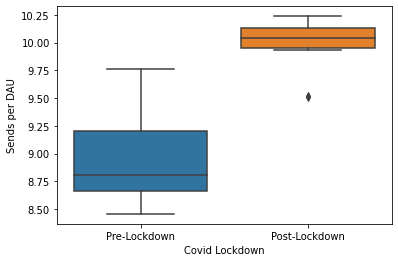

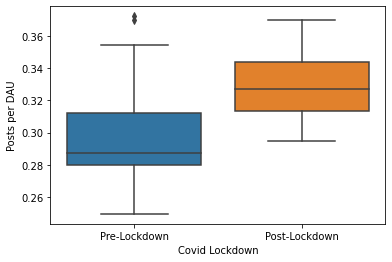

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the event_date column to a datetime type
df["event_date"] = pd.to_datetime(df["event_date"])

# Filter the dataset by the specified date ranges
date_range1 = pd.date_range(start="2020-02-20", end="2020-03-07")
date_range2 = pd.date_range(start="2020-03-12", end="2020-03-21")
df_filtered = df[(df["event_date"].isin(date_range1)) | (df["event_date"].isin(date_range2))]

# Group the data by event_date and calculate the average Send_per_uu and average Post_per_uu for each date range
df_grouped = df_filtered.groupby(["event_date"]).agg({"Send_per_uu": "mean", "Post_per_uu": "mean"})

# Reset the index so that event_date becomes a column
df_grouped = df_grouped.reset_index()

# Create a new column indicating the date range
df_grouped["date_range"] = pd.Series(["Pre-Lockdown"] * len(date_range1) + ["Post-Lockdown"] * len(date_range2))

# Create a box plot of Send_per_uu for each date range
sns.boxplot(x="date_range", y="Send_per_uu", data=df_grouped)

# Set the x-axis label
plt.xlabel("Covid Lockdown")
plt.ylabel("Sends per DAU")
# Show the plot
plt.show()

# Create a box plot of Post_per_uu for each date range
sns.boxplot(x="date_range", y="Post_per_uu", data=df_grouped)

# Set the x-axis label
plt.xlabel("Covid Lockdown")
plt.ylabel("Posts per DAU")
# Show the plot
plt.show()


## Plot 2: Pre vs Post LD Engagement by Age Group

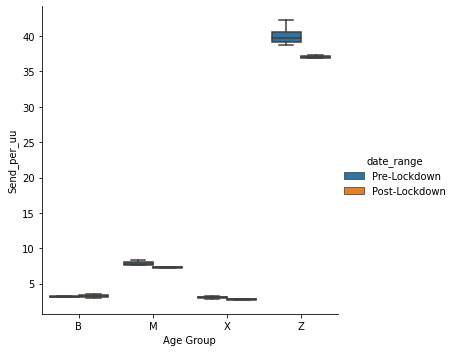

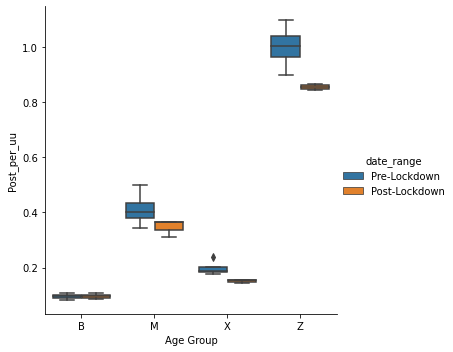

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert the event_date column to a datetime type
df["event_date"] = pd.to_datetime(df["event_date"])

# Filter the dataset by the specified date ranges
date_range1 = pd.date_range(start="2020-02-20", end="2020-03-07")
date_range2 = pd.date_range(start="2020-03-12", end="2020-03-21")
df_filtered = df[(df["event_date"].isin(date_range1)) | (df["event_date"].isin(date_range2))]

# Group the data by event_date, age_group, and calculate the average Send_per_uu and average Post_per_uu for each group
df_grouped = df_filtered.groupby(["event_date", "age_group"]).agg({"Send_per_uu": "mean", "Post_per_uu": "mean"})

# Reset the index so that event_date and age_group become columns
df_grouped = df_grouped.reset_index()

# Add a new column indicating the date range
df_grouped["date_range"] = pd.Series(["Pre-Lockdown"] * len(date_range1) + ["Post-Lockdown"] * len(date_range2))

# Create a box plot of Send_per_uu for each age group and date range
sns.catplot(x="age_group", y="Send_per_uu", hue="date_range", kind="box", data=df_grouped)

# Set the x-axis label
plt.xlabel("Age Group")

# Show the plot
plt.show()

# Create a box plot of Post_per_uu for each age group and date range
sns.catplot(x="age_group", y="Post_per_uu", hue="date_range", kind="box", data=df_grouped)

# Set the x-axis label
plt.xlabel("Age Group")

# Show the plot
plt.show()


### Analysis
We an uptick in both posts and sends after the lockdown period began in all three nordic countries.

# Closing Remarks
Overall we observed x effect from the post lockdown period


Our projections show a signifcant overall increase in snapchat usage after COVID. This follows our intuition, as people had more of a chance to engage with their mobile device when they were stuck at home and not working. 

In both Q1 and Q2, we forecast a significant increase in Snapchat daily active users. 

In our overall engagement trends, Snapchat users, on average, sent more Snapchats and posted more snapachat stories after nordic countries shut down on March 12, 2020. This trend was especially significant in Gen Z, as younger people had the largest increase in Snapchat engagement. 

# Old work (Delete Later)

In [ ]:
############ Model1
# Select certain number of historical days to use for training
#train_data = train_data[train_data['ds'] > train_data['ds'].max() - pd.Timedelta(days=40)]

# design model
m1 = Prophet(
   changepoint_prior_scale=0.4,
   n_changepoints=12,
   seasonality_prior_scale = 0.2,
   holidays = lockdowns,
   yearly_seasonality= True,
#  changepoints=['2020-03-13'],
#  weekly_seasonality=False,
)
m1.add_seasonality(name='weekly_pre_covid', period=7, fourier_order=3, condition_name='pre_covid',)
m1.add_seasonality(name='weekly_post_covid',period=7,fourier_order=3,condition_name='post_covid',)

# fit model
m1 = m1.fit(train_data)
future1 = m1.make_future_dataframe(periods=101)
future1['pre_covid'] = pd.to_datetime(future1['ds']) < pd.to_datetime('2020-03-13')
future1['post_covid'] = ~future1['pre_covid']

# predict
forecast1 = m1.predict(future1)

# forecast plot
plot_plotly(m1, forecast1)

#plot_components_plotly(m1, forecast1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
train_data = snap.groupby('event_date')['APP_APPLICATION_OPEN_UU'].sum().reset_index().rename(columns={'event_date': 'ds', 'APP_APPLICATION_OPEN_UU': 'y'})
train_data['ds'] = pd.to_datetime(train_data['ds'])

# lockdown period
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': -15, 'upper_window': 0}
])
for t_col in ['ds']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])

# forecast model
m1 = Prophet(changepoint_prior_scale=0.01,
             seasonality_prior_scale=0.8,
             holidays=lockdowns,
             weekly_seasonality=False)

# Add a weekly seasonality component for the last 9 days of data
train_data['last_9_days'] = (train_data['ds'] >= train_data['ds'].max() - pd.Timedelta(days=9)).astype(int)
m1.add_seasonality(
    name='weekly_last_9_days',
    period=7,
    fourier_order=3,
    condition_name='last_9_days',
)

# fit model
m1 = m1.fit(train_data)

# make future dataframe
future1 = m1.make_future_dataframe(periods=101)

# Add a column for the last 9 days of data to the future dataframe
future1['last_9_days'] = (future1['ds'] >= train_data['ds'].max() - pd.Timedelta(days=9)).astype(int)

# predict
forecast1 = m1.predict(future1)

# forecast plot
plot_plotly(m1, forecast1)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [ ]:
train_data

,ds,y,pre_covid,post_covid
0,2019-01-01,7012787,True,False
1,2019-01-02,6522305,True,False
2,2019-01-03,6457837,True,False
3,2019-01-04,6529505,True,False
4,2019-01-05,6650731,True,False
...,...,...,...,...
441,2020-03-17,7110274,False,True
442,2020-03-18,7128569,False,True
443,2020-03-19,7167179,False,True
444,2020-03-20,7237818,False,True


In [ ]:
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-13,0,2020-05-29,77


In [ ]:

m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)
m.train_holiday_names


###

# generate the forecast for the next 9 days
future_dates = pd.date_range(start=train_data['ds'].max()+pd.Timedelta(days=1), periods=90, freq='D')
future_data = pd.DataFrame({'ds': future_dates})

forecast = model.predict(future_data)['yhat'].values

# create a new DataFrame with the forecasted values
forecast_df1 = pd.DataFrame({'event_date': future_dates, 'APP_APPLICATION_OPEN_UU': forecast})
forecast_df1['event_date'] = forecast_df1['event_date'].apply(lambda x: x.date().strftime('%Y-%m-%d'))


In [ ]:

snapF = pd.concat([snapA, forecast_df1], ignore_index=True)


In [ ]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=snapF['event_date'], y=snapF['APP_APPLICATION_OPEN_UU'], mode='lines', name='APP_APPLICATION_OPEN_UU'))
fig.update_layout(title='Forecasted Usage', xaxis_title='Date', yaxis_title='DAY')
fig.update_traces(hoverinfo='text', hovertext=[f"event_date: {date}<br>APP_APPLICATION_OPEN_UU: {APP_APPLICATION_OPEN_UU:.2f}" for date, APP_APPLICATION_OPEN_UU in zip(snapAF['event_date'], snapAF['APP_APPLICATION_OPEN_UU'])])
fig.show()

In [ ]:
!pip install rpy2
%load_ext rpy2.ipython


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA


train_data = snap.groupby('event_date')['APP_APPLICATION_OPEN_UU'].sum().reset_index().rename(columns={'event_date': 'date', 'APP_APPLICATION_OPEN_UU': 'usage'})
train_data['date'] = pd.to_datetime(train_data['date'])

# Select the last 14 days of data
train_data = train_data[train_data['date'] > train_data['date'].max() - pd.Timedelta(days=120)]

# fit an ARIMA model to the training data
model = ARIMA(train_data.set_index('date'), order=(1, 1, 0))
model_fit = model.fit()

# generate the forecast for the next 9 days
future_dates = pd.date_range(start=train_data['date'].max()+pd.Timedelta(days=1), periods=9, freq='D')
forecast = model_fit.forecast(steps=9)[0]

# create a new DataFrame with the forecasted values
forecast_df1 = pd.DataFrame({'event_date': future_dates, 'APP_APPLICATION_OPEN_UU': forecast})
forecast_df1['event_date'] = forecast_df1['event_date'].apply(lambda x: x.date().strftime('%Y-%m-%d'))





/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

